# Overview
- LightGBM

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from tqdm.notebook import tqdm
import lightgbm as lgb
from typing import List, Union, Optional
import time
from contextlib import contextmanager
import sys
import logging
import category_encoders as ce
import plotly
from plotly import express as px
# import mlb

pd.options.display.max_columns = 100

## Config

In [2]:
class CFG:
    ######################
    # global #
    ######################
    INPUT_DIR = "../input/mlb-player-digital-engagement-forecasting"
    # INPUT_DIR = "../input/mlb-unnested-dataset" # for kaggle kernel
    OBJECT_ID = ["playerId", "date"]
    TARGETS = ["target1", "target2", "target3", "target4"]
    ######################
    # model #
    ######################
    LGB_PARAMS = {
        "objective": "mae",
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "max_depth": 6,
        "num_leaves": int(2 ** 6 * 0.8),
        "lambda_l1": 0.1,
        "lambda_l2": 0.1,
        "bagging_fraction": 0.9,
        "bagging_freq": 3,
        "feature_fraction": 0.9,
        "min_data_in_leaf": 20,
        "num_threads": 8,
        "verbosity": -1,
        "num_iterations": 10000,
        "early_stopping_round": 100,
    }
    SEEDS = [2434]

## Utils

In [3]:
def get_logger(out_file=None):
    logger = logging.getLogger()  # loggerの呼び出し
    formatter = logging.Formatter("[%(asctime)s] [%(levelname)s] [%(message)s]")  # ログ出力の際のフォーマットを定義
    logger.handlers = []  # ハンドラーを追加するためのリスト
    logger.setLevel(logging.INFO)  # ロギングのレベルを設定, 'INFO' : 想定された通りのことが起こったことの確認

    handler = logging.StreamHandler(sys.stdout)  # StreamHandler(コンソールに出力するハンドラ)を追加
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    # ログをファイルとして出力する際のハンドラ(FileHandler)
    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)

    logger.info("logger set up")  # "logger set up"を表示
    return logger


@contextmanager
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    msg = f"<{name}> start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"<{name}> done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float64)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Loading dataset

In [4]:
class MLBDataset(object):
    def __init__(self, input_path):
        self.input_path = Path(input_path)
        #################
        # train #
        #################
        self.train_next = pd.read_pickle(self.input_path / "train_nextDayPlayerEngagement.pickle")
        self.train_rosters = pd.read_pickle(self.input_path / "train_rosters.pickle")
        self.train_ptf = pd.read_pickle(self.input_path / "train_playerTwitterFollowers.pickle")
        self.train_scores = pd.read_pickle(self.input_path / "train_playerBoxScores.pickle")
        self.train_games = pd.read_pickle(self.input_path / "train_games.pickle")
        self.train_standings = pd.read_pickle(self.input_path / "train_standings.pickle")
        self.train_tbs = pd.read_pickle(self.input_path / "train_teamBoxScores.pickle")
        self.train_ttf = pd.read_pickle(self.input_path / "train_teamTwitterFollowers.pickle")
        self.train_trans = pd.read_pickle(self.input_path / "train_transactions.pickle")
        self.train_awards = pd.read_pickle(self.input_path / "train_awards.pickle")
        self.train_events = pd.read_pickle(self.input_path / "train_events.pickle")
        #################
        # Additional #
        #################
        self.players = pd.read_pickle(self.input_path / "players.pickle")
        self.awards = pd.read_pickle(self.input_path / "awards.pickle")
        self.seasons = pd.read_pickle(self.input_path / "seasons.pickle")
        self.teams = pd.read_pickle(self.input_path / "teams.pickle")
        #################
        # test #
        #################
        self.example_test = pd.read_csv(self.input_path / "example_test.csv")
        self.sample_submission = pd.read_csv(self.input_path / "example_sample_submission.csv")

mlb_train_ds = MLBDataset(CFG.INPUT_DIR)

In [5]:
mlb_train_ds.train_scores["year"] = pd.to_datetime(mlb_train_ds.train_scores["gameDate"]).dt.year
mlb_train_ds.train_scores.head()

date  home  gamePk    gameDate           gameTimeUTC  teamId  \
0  20180329     1  529418  2018-03-29  2018-03-29T23:08:00Z     119   
1  20180329     1  529406  2018-03-29  2018-03-29T20:00:00Z     139   
2  20180329     0  529416  2018-03-29  2018-03-29T20:10:00Z     143   
3  20180329     0  529412  2018-03-29  2018-03-29T20:05:00Z     108   
4  20180329     1  529408  2018-03-29  2018-03-29T20:15:00Z     118   

                teamName  playerId      playerName jerseyNum  positionCode  \
0    Los Angeles Dodgers    605131   Austin Barnes        15            12   
1         Tampa Bay Rays    605480    Mallex Smith         0             7   
2  Philadelphia Phillies    546318  Odubel Herrera        37             8   
3     Los Angeles Angels    527043     Jefry Marte        19             3   
4     Kansas City Royals    449181   Paulo Orlando        16             8   

   positionName positionType  battingOrder  gamesPlayedBatting  flyOuts  \
0  Pinch Runner       Runner         601.0                 1.0      0.0   
1    Outfielder   Outfielder         601.0                 1.0      0.0   
2    Outfielder   Outfielder         401.0                 1.0      0.0   
3    First Base    Infielder         402.0                 1.0      0.0   
4    Outfielder   Outfielder         701.0                 1.0      0.0   

   groundOuts  runsScored  doubles  triples  homeRuns  strikeOuts  \
0         0.0         0.0      0.0      0.0       0.0         0.0   
1         0.0         0.0      0.0      0.0       0.0         0.0   
2         0.0         0.0      0.0      0.0       0.0         0.0   
3         0.0         0.0      0.0      0.0       0.0         0.0   
4         0.0         0.0      0.0      0.0       0.0         0.0   

   baseOnBalls  intentionalWalks  hits  hitByPitch  atBats  caughtStealing  \
0          0.0               0.0   0.0         0.0     0.0             0.0   
1          0.0               0.0   0.0         0.0     0.0             0.0   
2          0.0               0.0   0.0         0.0     0.0             0.0   
3          0.0               0.0   0.0         0.0     0.0             0.0   
4          0.0               0.0   0.0         0.0     0.0             0.0   

   stolenBases  groundIntoDoublePlay  groundIntoTriplePlay  plateAppearances  \
0          0.0                   0.0                   0.0               0.0   
1          0.0                   0.0                   0.0               0.0   
2          0.0                   0.0                   0.0               0.0   
3          0.0                   0.0                   0.0               0.0   
4          0.0                   0.0                   0.0               0.0   

   totalBases  rbi  leftOnBase  sacBunts  sacFlies  catchersInterference  \
0         0.0  0.0         0.0       0.0       0.0                   0.0   
1         0.0  0.0         0.0       0.0       0.0                   0.0   
2         0.0  0.0         0.0       0.0       0.0                   0.0   
3         0.0  0.0         0.0       0.0       0.0                   0.0   
4         0.0  0.0         0.0       0.0       0.0                   0.0   

   pickoffs  gamesPlayedPitching  gamesStartedPitching  completeGamesPitching  \
0       0.0                  NaN                   NaN                    NaN   
1       0.0                  NaN                   NaN                    NaN   
2       0.0                  NaN                   NaN                    NaN   
3       0.0                  NaN                   NaN                    NaN   
4       0.0                  NaN                   NaN                    NaN   

   shutoutsPitching  winsPitching  lossesPitching  flyOutsPitching  \
0               NaN           NaN             NaN              NaN   
1               NaN           NaN             NaN              NaN   
2               NaN           NaN             NaN              NaN   
3               NaN           NaN             NaN              NaN   
4

In [6]:
df = mlb_train_ds.train_scores[mlb_train_ds.train_scores["playerName"] == "Shohei Ohtani"].copy()
df

date  home  gamePk    gameDate           gameTimeUTC  teamId  \
228     20180329     0  529412  2018-03-29  2018-03-29T20:05:00Z     108   
1475    20180401     0  529450  2018-04-01  2018-04-01T20:05:00Z     108   
1901    20180403     1  529475  2018-04-03  2018-04-04T02:07:00Z     108   
2446    20180404     1  529486  2018-04-04  2018-04-04T20:07:00Z     108   
2991    20180406     1  529514  2018-04-06  2018-04-07T02:07:00Z     108   
...          ...   ...     ...         ...                   ...     ...   
183129  20210425     0  634403  2021-04-25  2021-04-25T18:10:00Z     108   
183590  20210426     0  634377  2021-04-26  2021-04-27T00:05:00Z     108   
183833  20210427     0  634359  2021-04-27  2021-04-28T00:05:00Z     108   
184076  20210428     0  634350  2021-04-28  2021-04-29T00:05:00Z     108   
184853  20210430     0  634287  2021-04-30  2021-05-01T02:10:00Z     108   

                  teamName  playerId     playerName jerseyNum  positionCode  \
228     Los Angeles Angels    660271  Shohei Ohtani        17            10   
1475    Los Angeles Angels    660271  Shohei Ohtani        17             1   
1901    Los Angeles Angels    660271  Shohei Ohtani        17            10   
2446    Los Angeles Angels    660271  Shohei Ohtani        17            10   
2991    Los Angeles Angels    660271  Shohei Ohtani        17            10   
...                    ...       ...            ...       ...           ...   
183129  Los Angeles Angels    660271  Shohei Ohtani        17            10   
183590  Los Angeles Angels    660271  Shohei Ohtani        17             1   
183833  Los Angeles Angels    660271  Shohei Ohtani        17            10   
184076  Los Angeles Angels    660271  Shohei Ohtani        17            10   
184853  Los Angeles Angels    660271  Shohei Ohtani        17            10   

             positionName positionType  battingOrder  gamesPlayedBatting  \
228     Designated Hitter       Hitter         800.0                 1.0   
1475              Pitcher      Pitcher           NaN                 NaN   
1901    Designated Hitter       Hitter         800.0                 1.0   
2446    Designated Hitter       Hitter         800.0                 1.0   
2991    Designated Hitter       Hitter         800.0                 1.0   
...                   ...          ...           ...                 ...   
183129  Designated Hitter       Hitter         200.0                 1.0   
183590            Pitcher      Pitcher         200.0                 1.0   
183833  Designated Hitter       Hitter         200.0                 1.0   
184076  Designated Hitter       Hitter         200.0                 1.0   
184853  Designated Hitter       Hitter         200.0                 1.0   

        flyOuts  groundOuts  runsScored  doubles  triples  homeRuns  \
228         0.0         3.0         0.0      0.0      0.0       0.0   
1475        NaN         NaN         NaN      NaN      NaN       NaN   
1901        0.0         0.0         2.0      0.0      0.0       1.0   
2446        0.0         2.0         1.0      0.0      0.0       1.0   
2991        1.0         1.0         1.0      0.0      0.0       1.0   
...         ...         ...         ...      ...      ...       ...   
183129      1.0         1.0         1.0      0.0      0.0       1.0   
183590      0.0         0.0         3.0      1.0      0.0       0.0   
183833      2.0         1.0         0.0      0.0      0.0       0.0   
184076      0.0         1.0         0.0      1.0      0.0       0.0   
184853      1.0         2.0         1.0      0.0      0.0       1.0   

        strikeOuts  baseOnBalls  intentionalWalks  hits  hitByPitch  atBats  \
228            1.0          0.0               0.0   1.0         0.0     5.0   
1475           NaN          NaN               NaN   NaN         NaN     NaN   
1901           1.0          0.0               0.0   3.0         0.0     4.0   
2446           1.0          0.0               0.0   2.0         0.0 

In [150]:
agg_df = df.groupby(["year", "date"], as_index=False).agg(
    # 打撃編
    num_game = ("gamePk", "nunique"),
    plateAppearances = ("plateAppearances", np.sum),
    atBats = ("atBats", np.sum),
    hits = ("hits", np.sum),
    doubles = ("doubles", np.sum),
    triples = ("triples", np.sum),
    homeRuns = ("homeRuns", np.sum),
    rbi = ("rbi", np.sum),
    runsScored = ("runsScored", np.sum),
    totalBases = ("totalBases", np.sum),
    baseOnBalls = ("baseOnBalls", np.sum),
    hitByPitch = ("hitByPitch", np.sum),
    groundIntoDoublePlay = ("groundIntoDoublePlay", np.sum),
    strikeOuts = ("strikeOuts", np.sum),
    sacBunts = ("sacBunts", np.sum),
    sacFlies = ("sacFlies", np.sum),
    caughtStealing = ("caughtStealing", np.sum),
    stolenBases = ("stolenBases", np.sum),
    # 投手編
    gamesPlayedPitching = ("gamesPlayedPitching", np.sum),
    gamesStartedPicthing = ("gamesStartedPitching", np.sum),
    winsPitching = ("winsPitching", np.sum),
    lossesPitching = ("lossesPitching", np.sum),
    completeGamesPitching = ("completeGamesPitching", np.sum),
    shutoutsPitching = ("shutoutsPitching", np.sum),
    saves = ("saves", np.sum),
    holds = ("holds", np.sum),
    inningsPitched = ("inningsPitched", np.sum),
    runsPitching = ("runsPitching", np.sum),
    earnedRuns = ("earnedRuns", np.sum),
    pitchesThrown = ("pitchesThrown", np.sum),
    hitsPitching = ("hitsPitching", np.sum),
    homeRunsPitching = ("homeRunsPitching", np.sum),
    strikeOutsPitching = ("strikeOutsPitching", np.sum),
    baseOnBallsPitching = ("baseOnBallsPitching", np.sum),
    hitByPitchPitching = ("hitByPitchPitching", np.sum),
    balks = ("balks", np.sum),
    wildPitches = ("wildPitches", np.sum),
    atBatsPitching = ("atBatsPitching", np.sum),
    battersFaced = ("battersFaced", np.sum),
    sacFliesPitching = ("sacFliesPitching", np.sum),
)

agg_df["qs"] = ((agg_df["inningsPitched"] >= 6) & (agg_df["runsPitching"] <= 3)) * agg_df["gamesStartedPicthing"]
agg_df["hqs"] = ((agg_df["inningsPitched"] >= 7) & (agg_df["runsPitching"] <= 2)) * agg_df["gamesStartedPicthing"]

for col in agg_df.drop(columns=["year", "date"], axis=1).columns.tolist():
    col_ = col + "_cumsum"
    agg_df[col_] = agg_df.groupby(["year"], as_index=False)[col].cumsum()

# 打撃編
agg_df["battingAverage"] = agg_df["hits_cumsum"] / agg_df["atBats_cumsum"] # 打率
agg_df["sluggingPercentage"] = agg_df["totalBases_cumsum"] / agg_df["atBats_cumsum"] # 長打率
agg_df["onBasePercentage"] = (agg_df["hits_cumsum"] + agg_df["baseOnBalls_cumsum"] + agg_df["hitByPitch_cumsum"])/(agg_df["atBats_cumsum"] + agg_df["baseOnBalls_cumsum"] + agg_df["hitByPitch_cumsum"] + agg_df["sacFlies_cumsum"]) # 出塁率
agg_df["ops"] = agg_df["sluggingPercentage"] + agg_df["onBasePercentage"] # OPS
agg_df["isop"] = agg_df["sluggingPercentage"] - agg_df["battingAverage"] # IsoP
agg_df["isod"] = agg_df["onBasePercentage"] - agg_df["battingAverage"] # IsoD
agg_df["rc"] = (agg_df["hits_cumsum"] + agg_df["baseOnBalls_cumsum"]) * agg_df["totalBases_cumsum"] / (agg_df["atBats_cumsum"] + agg_df["baseOnBalls_cumsum"]) # RC
agg_df["rc27"] = agg_df["rc"] / (agg_df["atBats_cumsum"] - agg_df["hits_cumsum"] + agg_df["caughtStealing_cumsum"] + agg_df["sacBunts_cumsum"] + agg_df["sacFlies_cumsum"] + agg_df["groundIntoDoublePlay_cumsum"]) * 27 # RC27
agg_df["babip"] = (agg_df["hits_cumsum"] - agg_df["homeRuns_cumsum"]) / (agg_df["atBats_cumsum"] - agg_df["strikeOuts_cumsum"] - agg_df["homeRuns_cumsum"] + agg_df["sacFlies_cumsum"]) # BABIP
agg_df["bb_k"] = agg_df["baseOnBalls_cumsum"] / agg_df["strikeOuts_cumsum"] # BB/K
agg_df["k%"] = agg_df["strikeOuts_cumsum"] / agg_df["plateAppearances_cumsum"] # K%
# 投手編
agg_df["era"] = agg_df["earnedRuns_cumsum"] * 9 / agg_df["inningsPitched_cumsum"] # 防御率
agg_df["wp"] = agg_df["winsPitching_cumsum"] / (agg_df["winsPitching_cumsum"] + agg_df["lossesPitching_cumsum"]) # 勝率
agg_df["k9"] = agg_df["strikeOutsPitching_cumsum"] * 9 / agg_df["inningsPitched_cumsum"] # K/9(奪三振率)
agg_df["hits_allowed_average"] = agg_df["hitsPitching_cumsum"] / agg_df["atBatsPitching_cumsum"] # 被打率
agg_df["hp"] = agg_df["holds_cumsum"] + agg_df["winsPitching_cumsum"] # HP
agg_df["qs%"] = agg_df["qs_cumsum"] / agg_df["gamesStartedPicthing_cumsum"] # QS率
agg_df["hqs%"] = agg_df["hqs_cumsum"] / agg_df["gamesStartedPicthing_cumsum"] # HQS率
agg_df["k%_pitching"] = agg_df["strikeOutsPitching_cumsum"] / agg_df["battersFaced_cumsum"] # K%
agg_df["bb9"] = agg_df["baseOnBallsPitching_cumsum"] * 9 / agg_df["inningsPitched_cumsum"] # BB/9
agg_df["bb%"] = agg_df["baseOnBallsPitching_cumsum"] / agg_df["battersFaced_cumsum"] # BB%
agg_df["k_bb"] = agg_df["strikeOutsPitching_cumsum"] / (agg_df["baseOnBallsPitching_cumsum"] + agg_df["hitByPitchPitching_cumsum"]) # K/BB
agg_df["hr9"] = agg_df["homeRunsPitching_cumsum"] * 9 / agg_df["inningsPitched_cumsum"] # HR/9
agg_df["babip_pitching"] = (agg_df["hitsPitching_cumsum"] - agg_df["homeRunsPitching_cumsum"]) / (agg_df["atBatsPitching_cumsum"] - agg_df["strikeOutsPitching_cumsum"] - agg_df["homeRunsPitching_cumsum"] + agg_df["sacFliesPitching_cumsum"]) # BABIP
agg_df["whip"] = (agg_df["baseOnBallsPitching_cumsum"] + agg_df["hitsPitching_cumsum"]) / agg_df["inningsPitched_cumsum"] # WHIP

agg_df

year      date  num_game  plateAppearances  atBats  hits  doubles  \
0    2018  20180329         1               5.0     5.0   1.0      0.0   
1    2018  20180401         1               0.0     0.0   0.0      0.0   
2    2018  20180403         1               4.0     4.0   3.0      0.0   
3    2018  20180404         1               5.0     5.0   2.0      0.0   
4    2018  20180406         1               5.0     4.0   1.0      0.0   
..    ...       ...       ...               ...     ...   ...      ...   
282  2021  20210425         1               5.0     5.0   1.0      0.0   
283  2021  20210426         1               4.0     3.0   2.0      1.0   
284  2021  20210427         1               4.0     4.0   0.0      0.0   
285  2021  20210428         1               4.0     4.0   1.0      1.0   
286  2021  20210430         1               4.0     4.0   1.0      0.0   

     triples  homeRuns  rbi  runsScored  totalBases  baseOnBalls  hitByPitch  \
0        0.0       0.0  0.0         0.0         1.0          0.0         0.0   
1        0.0       0.0  0.0         0.0         0.0          0.0         0.0   
2        0.0       1.0  3.0         2.0         6.0          0.0         0.0   
3        0.0       1.0  2.0         1.0         5.0          0.0         0.0   
4        0.0       1.0  2.0         1.0         4.0          1.0         0.0   
..       ...       ...  ...         ...         ...          ...         ...   
282      0.0       1.0  1.0         1.0         4.0          0.0         0.0   
283      0.0       0.0  2.0         3.0         3.0          1.0         0.0   
284      0.0       0.0  0.0         0.0         0.0          0.0         0.0   
285      0.0       0.0  0.0         0.0         2.0          0.0         0.0   
286      0.0       1.0  1.0         1.0         4.0          0.0         0.0   

     groundIntoDoublePlay  strikeOuts  sacBunts  sacFlies  caughtStealing  \
0                     0.0         1.0       0.0       0.0             0.0   
1                     0.0         0.0       0.0       0.0             0.0   
2                     0.0         1.0       0.0       0.0             0.0   
3                     0.0         1.0       0.0       0.0             0.0   
4                     0.0         1.0       0.0       0.0             0.0   
..                    ...         ...       ...       ...             ...   
282                   0.0         2.0       0.0       0.0             0.0   
283                   0.0         1.0       0.0       0.0             0.0   
284                   0.0         1.0       0.0       0.0             0.0   
285                   0.0         1.0       0.0       0.0             0.0   
286                   0.0         0.0       0.0       0.0             0.0   

     stolenBases  gamesPlayedPitching  gamesStartedPicthing  winsPitching  \
0            0.0                  0.0                   0.0           0.0   
1            0.0                  1.0                   1.0           1.0   
2            0.0                  0.0                   0.0           0.0   
3            0.0                  0.0                   0.0           0.0   
4            0.0                  0.0                   0.0           0.0   
..           ...                  ...                   ...           ...   
282          0.0                  0.0                   0.0           0.0   
283          0.0                  1.0                   1.0           1.0   
284          0.0                  0.0                   0.0           0.0   
285          0.0                  0.0                   0.0           0.0   
286          0.0                  0.0                   0.0           0.0   

     lossesPitching  completeGamesPitching  shutoutsPitching  saves  holds  \
0               0.0                    0.0               0.0    0.0    0.0   
1               0.0                    0.0               0.0    0.0    0.0   
2               0.0                    0.0               0.0    0.0    

In [151]:
target_df = mlb_train_ds.train_next[mlb_train_ds.train_next["playerId"] == 660271].reset_index(drop=True).copy()
target_df

date engagementMetricsDate  playerId    target1     target2  \
0     20180101            2018-01-02    660271   0.000000    6.225681   
1     20180102            2018-01-03    660271   0.000000    3.578206   
2     20180103            2018-01-04    660271   0.000000    3.617216   
3     20180104            2018-01-05    660271   0.000000    4.491452   
4     20180105            2018-01-06    660271   0.000000    1.650581   
...        ...                   ...       ...        ...         ...   
1211  20210426            2021-04-27    660271  69.062271  100.000000   
1212  20210427            2021-04-28    660271   4.503799   37.984497   
1213  20210428            2021-04-29    660271  17.319229   40.329460   
1214  20210429            2021-04-30    660271   6.844256   36.335052   
1215  20210430            2021-05-01    660271  16.365822   48.650269   

         target3     target4  
0       0.000000   31.470589  
1       3.468022   16.180450  
2      20.326315   22.012037  
3       0.737624   34.008595  
4       0.096786   12.240974  
...          ...         ...  
1211  100.000000  100.000000  
1212   10.510792   52.950157  
1213   64.044350   38.428986  
1214   18.525476   46.073708  
1215   11.077387   44.349606  

[1216 rows x 7 columns]

In [152]:
target_df = target_df.merge(agg_df, on=["date"], how="left").drop(columns=["year"], axis=1)
target_df

date engagementMetricsDate  playerId    target1     target2  \
0     20180101            2018-01-02    660271   0.000000    6.225681   
1     20180102            2018-01-03    660271   0.000000    3.578206   
2     20180103            2018-01-04    660271   0.000000    3.617216   
3     20180104            2018-01-05    660271   0.000000    4.491452   
4     20180105            2018-01-06    660271   0.000000    1.650581   
...        ...                   ...       ...        ...         ...   
1211  20210426            2021-04-27    660271  69.062271  100.000000   
1212  20210427            2021-04-28    660271   4.503799   37.984497   
1213  20210428            2021-04-29    660271  17.319229   40.329460   
1214  20210429            2021-04-30    660271   6.844256   36.335052   
1215  20210430            2021-05-01    660271  16.365822   48.650269   

         target3     target4  num_game  plateAppearances  atBats  hits  \
0       0.000000   31.470589       NaN               NaN     NaN   NaN   
1       3.468022   16.180450       NaN               NaN     NaN   NaN   
2      20.326315   22.012037       NaN               NaN     NaN   NaN   
3       0.737624   34.008595       NaN               NaN     NaN   NaN   
4       0.096786   12.240974       NaN               NaN     NaN   NaN   
...          ...         ...       ...               ...     ...   ...   
1211  100.000000  100.000000       1.0               4.0     3.0   2.0   
1212   10.510792   52.950157       1.0               4.0     4.0   0.0   
1213   64.044350   38.428986       1.0               4.0     4.0   1.0   
1214   18.525476   46.073708       NaN               NaN     NaN   NaN   
1215   11.077387   44.349606       1.0               4.0     4.0   1.0   

      doubles  triples  homeRuns  rbi  runsScored  totalBases  baseOnBalls  \
0         NaN      NaN       NaN  NaN         NaN         NaN          NaN   
1         NaN      NaN       NaN  NaN         NaN         NaN          NaN   
2         NaN      NaN       NaN  NaN         NaN         NaN          NaN   
3         NaN      NaN       NaN  NaN         NaN         NaN          NaN   
4         NaN      NaN       NaN  NaN         NaN         NaN          NaN   
...       ...      ...       ...  ...         ...         ...          ...   
1211      1.0      0.0       0.0  2.0         3.0         3.0          1.0   
1212      0.0      0.0       0.0  0.0         0.0         0.0          0.0   
1213      1.0      0.0       0.0  0.0         0.0         2.0          0.0   
1214      NaN      NaN       NaN  NaN         NaN         NaN          NaN   
1215      0.0      0.0       1.0  1.0         1.0         4.0          0.0   

      hitByPitch  groundIntoDoublePlay  strikeOuts  sacBunts  sacFlies  \
0            NaN                   NaN         NaN       NaN       NaN   
1            NaN                   NaN         NaN       NaN       NaN   
2            NaN                   NaN         NaN       NaN       NaN   
3            NaN                   NaN         NaN       NaN       NaN   
4            NaN                   NaN         NaN       NaN       NaN   
...          ...                   ...         ...       ...       ...   
1211         0.0                   0.0         1.0       0.0       0.0   
1212         0.0                   0.0         1.0       0.0       0.0   
1213         0.0                   0.0         1.0       0.0       0.0   
1214         NaN                   NaN         NaN       NaN       NaN   
1215         0.0                   0.0         0.0       0.0       0.0   

      caughtStealing  stolenBases  gamesPlayedPitching  gamesStartedPicthing  \
0                NaN          NaN                  NaN                   NaN   
1                NaN          NaN                  NaN                   NaN   
2                NaN          NaN                  NaN                   NaN   
3                NaN          NaN                  NaN                   NaN   
4                N

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

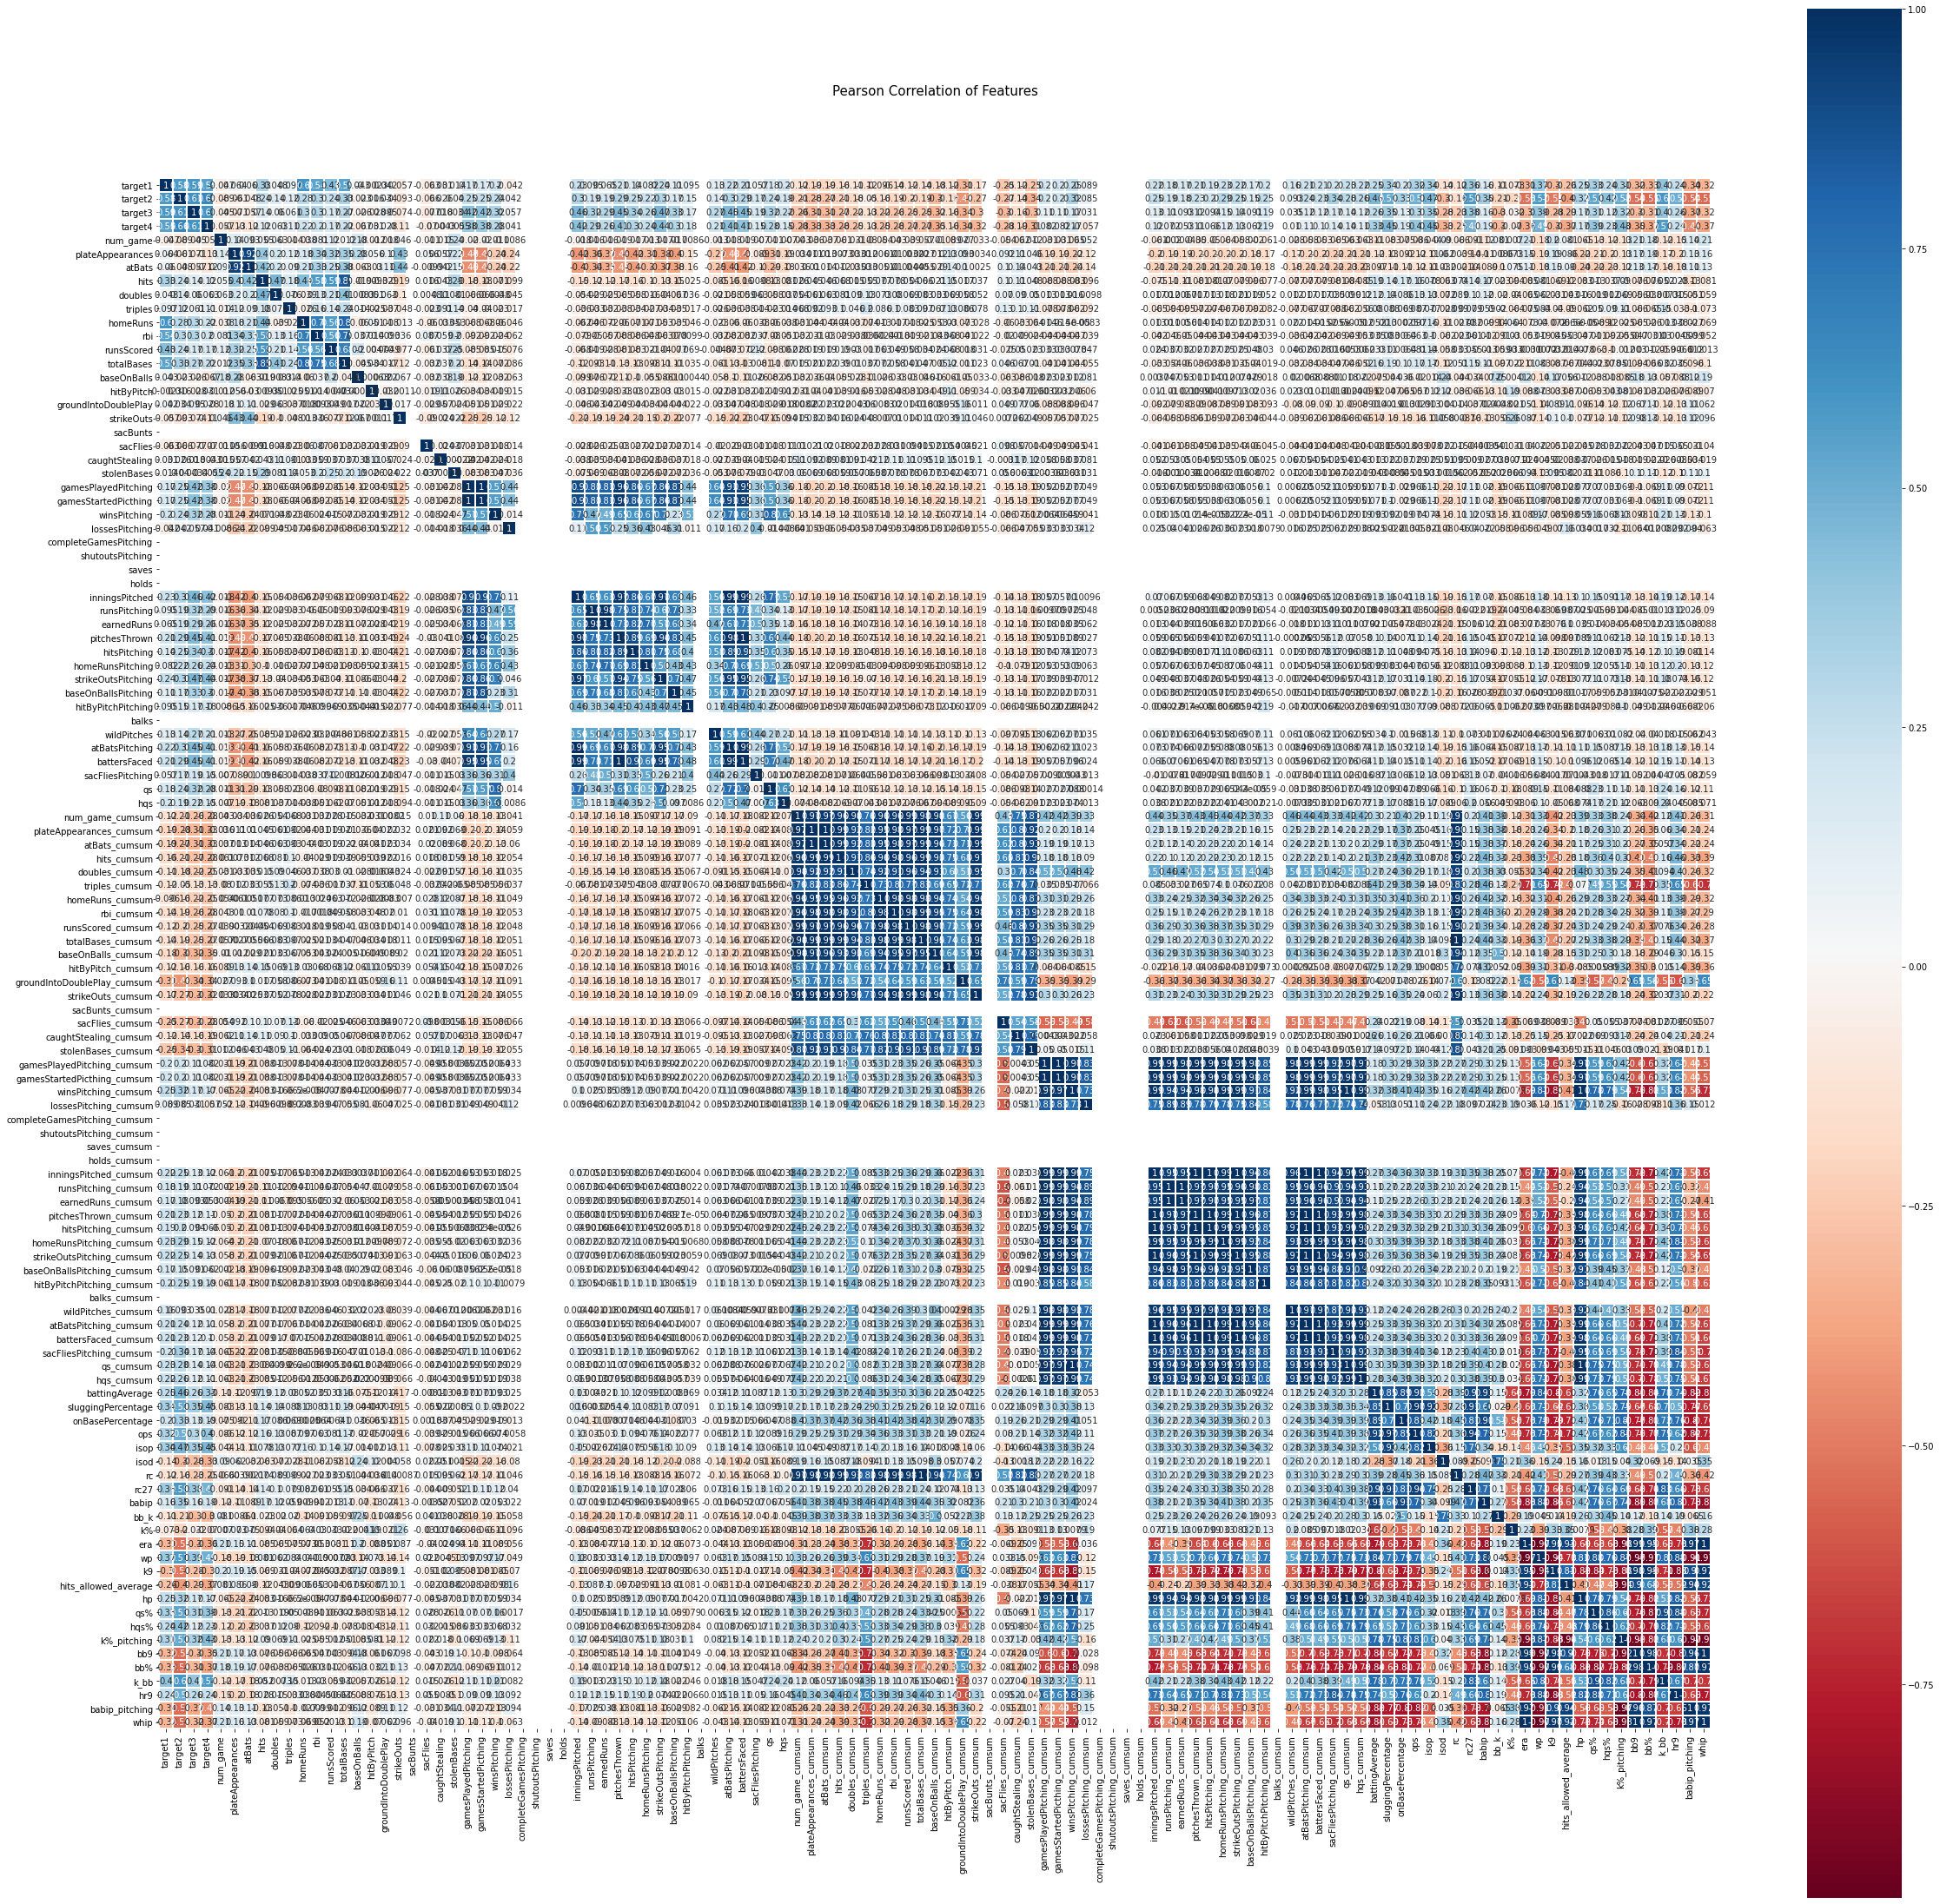

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = plt.cm.RdBu
plt.figure(figsize=(40,40))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(target_df.drop(columns=["date", "engagementMetricsDate", "playerId"]).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## Feature blocks

In [12]:
def merge_by_key(left: Union[pd.DataFrame, pd.Series], right: pd.DataFrame, on=CFG.OBJECT_ID) -> pd.DataFrame:
    if not isinstance(left, pd.Series):
        left = left[on]
    return pd.merge(left, right, on=on, how="left").drop(columns=on)


class BaseBlock(object):
    def fit(self, input_df: pd.DataFrame, y=None) -> pd.DataFrame:
        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        return NotImplementedError()


# class LagBlock(BaseBlock):
#     def __init__(self, column: str, periods: List[int]):
#         self.column = column
#         self.periods = periods

#     def fit(self, input_df: pd.DataFrame, y=None):
#         agg_list = [input_df.groupby(["playerId"], as_index=False)[self.column].transform(lambda x: x.shift(periods=period)).add_prefix(f"{period}_") for period in self.periods]
#         self.agg_df = pd.concat(agg_list, axis=1)

#         return self.transform(input_df)

#     def transform(self, input_df: pd.DataFrame):
#         return self.agg_df.add_prefix("Lag_")


def quantile25(x: pd.Series):
    return x.quantile(q=0.25)


def quantile75(x: pd.Series):
    return x.quantile(q=0.75)


class TargetAggregateBlock(BaseBlock):
    def fit(self, input_df: pd.DataFrame, y=None):
        dfs = [mlb_train_ds.train_next.groupby(["playerId"])[col].agg([
            "mean", "std", "max", "min", "median", quantile25, quantile75
            ]).add_prefix(f"{col}_") for col in CFG.TARGETS]
        self.agg_df = pd.concat(dfs, axis=1).reset_index()

        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame):
        return merge_by_key(input_df, self.agg_df, on="playerId")


class PlayersLabelEncodingBlock(BaseBlock):
    def __init__(self, columns: List[str]):
        self.columns = columns + ["playerId"]
        self.labeled_df = mlb_train_ds.players[self.columns].copy()
        self.labeled_df["playerid"] = self.labeled_df["playerId"]
        self.columns = self.columns + ["playerid"]
        self.encoder = None
    
    def fit(self, input_df: pd.DataFrame, y=None):
        self.encoder = ce.OrdinalEncoder(handle_unknown="value", handle_missing="values")
        self.encoder.fit(self.labeled_df[self.columns])
        self.labeled_df[self.columns] = self.encoder.transform(self.labeled_df[self.columns])

        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame):
        return merge_by_key(input_df, self.labeled_df, on="playerId").add_prefix("Players_LE_")


class RostersLabelEncodingBlock(BaseBlock):
    def __init__(self, columns: List[str]):
        self.columns = columns
        self.encoder = None

    def fit(self, input_df: pd.DataFrame, y=None):
        rosters_df = mlb_train_ds.train_rosters[self.columns]
        self.encoder = ce.OrdinalEncoder(handle_unknown="value", handle_missing="value")
        self.encoder.fit(rosters_df[self.columns])

        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame):
        self.labeled_df = mlb_train_ds.train_rosters[CFG.OBJECT_ID + self.columns].copy()
        self.labeled_df[self.columns] = self.encoder.transform(self.labeled_df[self.columns])

        return merge_by_key(input_df, self.labeled_df).add_prefix("Rosters_LE_")

    
class PlayerBoxScoresCountBlock(BaseBlock):
    def __init__(self, columns: List[str]):
        self.columns = columns

    def transform(self, input_df: pd.DataFrame):
        self.agg_df = mlb_train_ds.train_scores.groupby(CFG.OBJECT_ID)[self.columns].sum().reset_index()
        
        return merge_by_key(input_df, self.agg_df).add_prefix("PlayerBoxScoresCount_")


class TeamBoxScoresCountBlock(BaseBlock):
    def __init__(self, columns: List[str]):
        self.columns = columns

    def transform(self, input_df: pd.DataFrame):
        input_df = input_df.merge(mlb_train_ds.train_rosters[["date", "playerId", "teamId"]], on=["playerId", "date"], how="left")
        self.agg_df = mlb_train_ds.train_tbs.groupby(["teamId", "date"])[self.columns].sum().reset_index()

        return merge_by_key(input_df, self.agg_df, on=["teamId", "date"]).add_prefix("TeamBoxScoresCount_")


class GamesCountBlock(BaseBlock):
    def __init__(self, columns: List[str]):
        self.columns = columns

    def transform(self, input_df: pd.DataFrame):
        games_df = mlb_train_ds.train_scores[["date", "playerId", "gamePk"]].merge(mlb_train_ds.train_games, on=["date", "gamePk"], how="left")
        self.agg_df = games_df.groupby(["date", "playerId"])[self.columns].sum().reset_index()

        return merge_by_key(input_df, self.agg_df).add_prefix("GamesCount_")


class PlayerTwitterFollowerAggregateBlock(BaseBlock):
    def fit(self, input_df: pd.DataFrame, y=None):
        self.agg_df = mlb_train_ds.train_ptf.groupby(["playerId"])["numberOfFollowers"].agg([
            "mean", "std", "max", "min", "median", quantile25, quantile75])

        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame):
        return merge_by_key(input_df, self.agg_df, on="playerId").add_prefix("PlayerTwitterFollowerAggregate_")

In [13]:
def create_train_feature(input_df: pd.DataFrame, y: np.ndarray, update_blocks: list, non_update_blocks: list) -> pd.DataFrame:
    feat_df = pd.DataFrame()
    blocks = update_blocks + non_update_blocks

    for block in blocks:
        with timer(name=f"{str(block) + '_fit'}", logger=logger):
            try:
                out_feat_block = block.fit(input_df, y=y)
            except Exception as e:
                print(f"Error on {block} fit.")
                raise e from e

            assert len(out_feat_block) == len(input_df), block

        feat_df = pd.concat([feat_df, out_feat_block], axis=1)

    return feat_df


def create_test_feature(input_df: pd.DataFrame, update_blocks: list, non_update_blocks: list) -> pd.DataFrame:
    is_update = True if len(update_blocks) != 0 else False
    update_feat_df = pd.DataFrame()
    non_update_feat_df = pd.DataFrame()
    
    if is_update:
        for block in update_blocks:
            with timer(name=f"{str(block) + '_update'}", logger=logger):
                try:
                    out_feat_block = block.fit(input_df)
                except Exception as e:
                    print(f"Error on {block} transform.")
                    raise e from e

            update_feat_df = pd.concat([update_feat_df, out_feat_block], axis=1)
        

    for block in non_update_blocks:
        with timer(name=f"{str(block) + '_transform'}", logger=logger):
            try:
                out_feat_block = block.transform(input_df)
            except Exception as e:
                print(f"Error on {block} transform.")
                raise e from e

            assert len(out_feat_block) == len(input_df), block

        non_update_feat_df = pd.concat([non_update_feat_df, out_feat_block], axis=1)

    feat_df = pd.concat([update_feat_df, non_update_feat_df], axis=1) if is_update else non_update_feat_df

    return feat_df

## CV

In [14]:
def get_timeseries_holdout(train_df: pd.DataFrame, valid_start_date: int) -> List[tuple]:
    fold = []
    train_idx = np.array(train_df[train_df["date"] < valid_start_date].index)
    valid_idx = np.array(train_df[train_df["date"] >= valid_start_date].index)
    fold.append((train_idx, valid_idx))

    return fold

## Model

In [15]:
class LightGBMTrainer:
    def __init__(self, params: dict, seeds: List[int]):
        self.params = params
        self.seeds = seeds
        self.models = []

    def fit(self, X_train: np.ndarray, y_train: np.ndarray, cv: List[tuple]):
        oof_all = []
        for i, seed in enumerate(self.seeds):
            self.params["seed"] = seed

            for train_idx, valid_idx in cv:
                X_train_fold = X_train[train_idx]
                X_valid_fold = X_train[valid_idx]

                y_train_fold = y_train[train_idx]
                y_valid_fold = y_train[valid_idx]

                train_set = lgb.Dataset(X_train_fold, y_train_fold)
                valid_set = lgb.Dataset(X_valid_fold, y_valid_fold, reference=train_set)

                model = lgb.train(
                    params=self.params,
                    train_set=train_set,
                    valid_sets=[train_set, valid_set],
                    verbose_eval=100,
                )

                y_oof = model.predict(X_valid_fold, num_iteration=model.best_iteration)
                oof_all.append(y_oof)
                self.models.append(model)

        oof_all = np.mean(oof_all, axis=0)
        oof_score = mean_absolute_error(oof_all, y_valid_fold)

        return oof_score, self.models

    def predict(self, X_test: np.ndarray):
        y_pred = np.mean([model.predict(X_test) for model in self.models], axis=0)

        return y_pred


def run_lgb(X_train, targets, params, seeds, fold):
    cv_scores = []
    models = []

    for i, target in enumerate(targets):
        print(f"Traning for Target{i+1}")
        trainer = LightGBMTrainer(params, seeds)
        oof_score_tmp, models_tmp = trainer.fit(X_train, target, fold)
        cv_scores.append(oof_score_tmp)
        models.append(models_tmp)
        print(f"Local Target{i+1} OOF-MAE : {np.mean(oof_score_tmp)}")
        print("-"*50)

    print(f"Local MCMAE : {np.mean(cv_scores)}")

    return models

## Training

In [16]:
# set-up logger
logger = get_logger()

# create feature
update_blocks = []
non_update_blocks = [
    TargetAggregateBlock(),
    RostersLabelEncodingBlock(columns=[
        "teamId",
        "status"
        ]
    ),
    PlayersLabelEncodingBlock(columns=[
        "birthCountry",
        "primaryPositionCode",
    ]),
    PlayerBoxScoresCountBlock(columns=[
        # 'date',
        'home',
        # 'gamePk',
        # 'gameDate',
        # 'gameTimeUTC',
        # 'teamId',
        # 'teamName',
        # 'playerId',
        # 'playerName',
        'jerseyNum',
        # 'positionCode',
        # 'positionName',
        # 'positionType',
        'battingOrder',
        'gamesPlayedBatting',
        'flyOuts',
        'groundOuts',
        'runsScored',
        'doubles',
        'triples',
        'homeRuns',
        'strikeOuts',
        'baseOnBalls',
        'intentionalWalks',
        'hits',
        'hitByPitch',
        'atBats',
        'caughtStealing',
        'stolenBases',
        'groundIntoDoublePlay',
        'groundIntoTriplePlay',
        'plateAppearances',
        'totalBases',
        'rbi',
        'leftOnBase',
        'sacBunts',
        'sacFlies',
        'catchersInterference',
        'pickoffs',
        'gamesPlayedPitching',
        'gamesStartedPitching',
        'completeGamesPitching',
        'shutoutsPitching',
        'winsPitching',
        'lossesPitching',
        'flyOutsPitching',
        'airOutsPitching',
        'groundOutsPitching',
        'runsPitching',
        'doublesPitching',
        'triplesPitching',
        'homeRunsPitching',
        'strikeOutsPitching',
        'baseOnBallsPitching',
        'intentionalWalksPitching',
        'hitsPitching',
        'hitByPitchPitching',
        'atBatsPitching',
        'caughtStealingPitching',
        'stolenBasesPitching',
        'inningsPitched',
        'saveOpportunities',
        'earnedRuns',
        'battersFaced',
        'outsPitching',
        'pitchesThrown',
        'balls',
        'strikes',
        'hitBatsmen',
        'balks',
        'wildPitches',
        'pickoffsPitching',
        'rbiPitching',
        'gamesFinishedPitching',
        'inheritedRunners',
        'inheritedRunnersScored',
        'catchersInterferencePitching',
        'sacBuntsPitching',
        'sacFliesPitching',
        'saves',
        'holds',
        'blownSaves',
        'assists',
        'putOuts',
        'errors',
        'chances'
        ]
    ),
    TeamBoxScoresCountBlock(columns=[
        # 'date',
        # 'home',
        # 'teamId',
        # 'gamePk',
        # 'gameDate',
        # 'gameTimeUTC',
        'flyOuts',
        'groundOuts',
        'runsScored',
        'doubles',
        'triples',
        'homeRuns',
        'strikeOuts',
        'baseOnBalls',
        'intentionalWalks',
        'hits',
        'hitByPitch',
        'atBats',
        'caughtStealing',
        'stolenBases',
        'groundIntoDoublePlay',
        'groundIntoTriplePlay',
        'plateAppearances',
        'totalBases',
        'rbi',
        'leftOnBase',
        'sacBunts',
        'sacFlies',
        'catchersInterference',
        'pickoffs',
        'airOutsPitching',
        'groundOutsPitching',
        'runsPitching',
        'doublesPitching',
        'triplesPitching',
        'homeRunsPitching',
        'strikeOutsPitching',
        'baseOnBallsPitching',
        'intentionalWalksPitching',
        'hitsPitching',
        'hitByPitchPitching',
        'atBatsPitching',
        'caughtStealingPitching',
        'stolenBasesPitching',
        'inningsPitched',
        'earnedRuns',
        'battersFaced',
        'outsPitching',
        'hitBatsmen',
        'balks',
        'wildPitches',
        'pickoffsPitching',
        'rbiPitching',
        'inheritedRunners',
        'inheritedRunnersScored',
        'catchersInterferencePitching',
        'sacBuntsPitching',
        'sacFliesPitching'
        ]
    ),
    GamesCountBlock(columns=[
        # 'date',
        # 'gamePk',
        # 'gameType',
        # 'season',
        # 'gameDate',
        # 'gameTimeUTC',
        # 'resumeDate',
        # 'resumedFrom',
        # 'codedGameState',
        # 'detailedGameState',
        'isTie',
        'gameNumber',
        'doubleHeader',
        # 'dayNight',
        'scheduledInnings',
        'gamesInSeries',
        # 'seriesDescription',
        # 'homeId',
        # 'homeName',
        # 'homeAbbrev',
        'homeWins',
        'homeLosses',
        'homeWinPct',
        # 'homeWinner',
        'homeScore',
        # 'awayId',
        # 'awayName',
        # 'awayAbbrev',
        'awayWins',
        'awayLosses',
        'awayWinPct',
        # 'awayWinner',
        'awayScore'
        ]
    ),
    PlayerTwitterFollowerAggregateBlock(),
]

y = mlb_train_ds.train_next["target1"].values
input_df = mlb_train_ds.train_next[CFG.OBJECT_ID].copy()
train_feat_df = create_train_feature(input_df, y, update_blocks, non_update_blocks)
X_train = train_feat_df.values
targets = [mlb_train_ds.train_next[col].values for col in CFG.TARGETS]

# split train/valid
fold = get_timeseries_holdout(input_df, valid_start_date=20210401)

# training
models = run_lgb(X_train, targets, CFG.LGB_PARAMS, CFG.SEEDS, fold)

[2021-07-07 23:26:26,809] [INFO] [logger set up]
[2021-07-07 23:26:26,914] [INFO] [<<__main__.TargetAggregateBlock object at 0x1c2238640>_fit> start]
[2021-07-07 23:26:36,203] [INFO] [<<__main__.TargetAggregateBlock object at 0x1c2238640>_fit> done in 9.29 s]
[2021-07-07 23:26:36,267] [INFO] [<<__main__.RostersLabelEncodingBlock object at 0x1c22384f0>_fit> start]
[2021-07-07 23:26:37,381] [INFO] [<<__main__.RostersLabelEncodingBlock object at 0x1c22384f0>_fit> done in 1.11 s]
[2021-07-07 23:26:37,598] [INFO] [<<__main__.PlayersLabelEncodingBlock object at 0x1c221f760>_fit> start]
[2021-07-07 23:26:37,865] [INFO] [<<__main__.PlayersLabelEncodingBlock object at 0x1c221f760>_fit> done in 0.27 s]
[2021-07-07 23:26:38,093] [INFO] [<<__main__.PlayerBoxScoresCountBlock object at 0x1c221fa60>_fit> start]
[2021-07-07 23:26:40,127] [INFO] [<<__main__.PlayerBoxScoresCountBlock object at 0x1c221fa60>_fit> done in 2.03 s]
[2021-07-07 23:26:40,698] [INFO] [<<__main__.TeamBoxScoresCountBlock object a

/Users/azupero/data-science/kaggle/MLB-Player-Digital-Engagement-Forecasting/.venv/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/azupero/data-science/kaggle/MLB-Player-Digital-Engagement-Forecasting/.venv/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.51266	valid_1's l1: 0.700532
[200]	training's l1: 0.512409	valid_1's l1: 0.699725
[300]	training's l1: 0.512369	valid_1's l1: 0.699531
Early stopping, best iteration is:
[277]	training's l1: 0.512371	valid_1's l1: 0.699519
Local Target1 OOF-MAE : 0.6995188802843717
--------------------------------------------------
Traning for Target2


/Users/azupero/data-science/kaggle/MLB-Player-Digital-Engagement-Forecasting/.venv/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/azupero/data-science/kaggle/MLB-Player-Digital-Engagement-Forecasting/.venv/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	training's l1: 1.7603	valid_1's l1: 1.51034
Early stopping, best iteration is:
[35]	training's l1: 1.77213	valid_1's l1: 1.5026
Local Target2 OOF-MAE : 1.5025952777897913
--------------------------------------------------
Traning for Target3


/Users/azupero/data-science/kaggle/MLB-Player-Digital-Engagement-Forecasting/.venv/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/azupero/data-science/kaggle/MLB-Player-Digital-Engagement-Forecasting/.venv/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.668506	valid_1's l1: 0.55332
[200]	training's l1: 0.66835	valid_1's l1: 0.553266
Early stopping, best iteration is:
[153]	training's l1: 0.668388	valid_1's l1: 0.553239
Local Target3 OOF-MAE : 0.5532389298829665
--------------------------------------------------
Traning for Target4


/Users/azupero/data-science/kaggle/MLB-Player-Digital-Engagement-Forecasting/.venv/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/azupero/data-science/kaggle/MLB-Player-Digital-Engagement-Forecasting/.venv/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.792593	valid_1's l1: 1.13368
[200]	training's l1: 0.791798	valid_1's l1: 1.1324
[300]	training's l1: 0.791756	valid_1's l1: 1.1324
Early stopping, best iteration is:
[222]	training's l1: 0.791783	valid_1's l1: 1.13233
Local Target4 OOF-MAE : 1.1323322614765632
--------------------------------------------------
Local MCMAE : 0.9719213373584232


In [17]:
def visualize_feature_importance(models, feat_train_df) -> plotly.graph_objects.Figure:
    '''LightGBMのfeature importanceを可視化
    '''
    for target_i in range(len(models)):
        feature_importance_df = pd.DataFrame()
        for i, model in enumerate(models[target_i]):
            _df = pd.DataFrame()
            _df['feature_importance'] = model.feature_importance(importance_type="gain")
            _df['feature'] = feat_train_df.columns
            _df['model_no'] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, _df], 
                                            axis=0, ignore_index=True)

        order = feature_importance_df.groupby('feature')\
            .mean()[['feature_importance']]\
            .sort_values('feature_importance', ascending=False).index[:50]
        
        fig = px.box(
            feature_importance_df.query("feature in @order"),
            x="feature_importance",
            y="feature",
            category_orders={"feature": order},
            width=1250,
            height=900,
            title=f"Target{target_i+1} Top 50 feature importance",
        )
        fig.update_yaxes(showgrid=True)
        fig.show()

In [18]:
visualize_feature_importance(models, train_feat_df)

## Inference

In [ ]:
def update_dataset(input_df: pd.DataFrame, sample_prediction_df: pd.DataFrame):
    '''datasetの更新
    '''
    # columnがNaNでなければ分岐処理が実行される(pd.isnaとかでも代用可)
    # NaN == NaNはFalseになる
    ####################
    # rosters #
    ####################
    if input_df["rosters"].iloc[0] == input_df["rosters"].iloc[0]:
        test_rosters = pd.read_json(input_df["rosters"].iloc[0])
    else:
        test_rosters = sample_prediction_df[["playerId"]].copy()
        for col in mlb_train_ds.train_rosters.columns:
            if col == "playerId": continue
            test_rosters[col] = np.nan

    test_rosters["date"] = input_df.iloc[0]["date"]
    if input_df.iloc[0]["date"] > 20210430:
        mlb_train_ds.train_rosters = reduce_mem_usage(pd.concat([mlb_train_ds.train_rosters, test_rosters], axis=0, ignore_index=True))
    ####################
    # playerBoxScores #
    ####################
    if input_df["playerBoxScores"].iloc[0] == input_df["playerBoxScores"].iloc[0]:
        test_scores = pd.read_json(input_df["playerBoxScores"].iloc[0])
    else:
        test_scores = sample_prediction_df[["playerId"]].copy()
        for col in mlb_train_ds.train_scores.columns:
            if col == "playerId": continue
            test_scores[col] = np.nan
    
    test_scores["date"] = input_df.iloc[0]["date"]
    if input_df.iloc[0]["date"] > 20210430:
        mlb_train_ds.train_scores = reduce_mem_usage(pd.concat([mlb_train_ds.train_scores, test_scores], axis=0, ignore_index=True))
    ####################
    # teamBoxScores #
    ####################
    if input_df["teamBoxScores"].iloc[0] == input_df["teamBoxScores"].iloc[0]:
        test_teamBoxScores = pd.read_json(input_df["teamBoxScores"].iloc[0])
    else:
        cols = mlb_train_ds.train_tbs.drop(columns="date", axis=1).columns.tolist()
        test_teamBoxScores = pd.DataFrame(columns=cols)
        test_teamBoxScores["teamId"] = mlb_train_ds.train_tbs.teamId.unique()

    test_teamBoxScores["date"] = input_df.iloc[0]["date"]
    if input_df.iloc[0]["date"] > 20210430:
        mlb_train_ds.train_tbs = reduce_mem_usage(pd.concat([mlb_train_ds.train_tbs, test_teamBoxScores], axis=0, ignore_index=True))
    ####################
    # games #
    ####################
    if input_df["games"].iloc[0] == input_df["games"].iloc[0]:
        test_games = pd.read_json(input_df["games"].iloc[0])
    else:
        cols = mlb_train_ds.train_games.drop(columns="date", axis=1).columns.tolist()
        test_games = pd.DataFrame(columns=cols)

    test_games["date"] = input_df.iloc[0]["date"]
    if input_df.iloc[0]["date"] > 20210430:
        mlb_train_ds.train_games = reduce_mem_usage(pd.concat([mlb_train_ds.train_games, test_games], axis=0, ignore_index=True))

In [ ]:
# env = mlb.make_env()
# iter_test = env.iter_test()

# for (test_df, sample_prediction_df) in iter_test:
#     sample_prediction_df = sample_prediction_df.reset_index(drop=True)
#     # create dataset
#     test_df = test_df.reset_index()
#     test_df = test_df.rename(columns={"index": "date"})
#     sample_prediction_df["date"] = test_df.iloc[0]["date"]
#     sample_prediction_df["playerId"] = sample_prediction_df["date_playerId"].map(lambda x: int(x.split("_")[1]))
#     update_dataset(test_df, sample_prediction_df)
#     # create features
#     test_feat_df = create_test_feature(sample_prediction_df, update_blocks, non_update_blocks)
#     X_test = test_feat_df.values
#     # prediction
#     for target, model in zip(CFG.TARGETS, models):
#         pred = np.mean([model_.predict(X_test) for model_ in model], axis=0)
#         sample_prediction_df[target] = np.clip(pred, 0, 100)

#     sample_prediction_df = sample_prediction_df.drop(columns=["playerId", "date"], axis=1)

#     env.predict(sample_prediction_df)